# Neural Network Analysis with Safetensors

Welcome to this notebook! In this session, we'll explore how to analyze neural network models stored in the `.safetensors` format. This format is commonly used for efficiently storing and loading large model weights, particularly for transformer-based models. We'll use a custom `SafetensorsAnalyzer` class to perform a comprehensive analysis of a model's architecture, parameters, and weights.

## What You'll Learn
By the end of this notebook, you will:
- Understand how to load and inspect `.safetensors` model files using Python.
- Analyze model architecture, including layer types, parameter distributions, and memory usage.
- Visualize key model characteristics through various plots, such as:
  - Architecture overview
  - Parameter distributions
  - Layer type analysis
  - Weight distributions
  - Tensor shape analysis
  - Memory footprint analysis
  - Layer-wise parameter counts
  - Weight magnitude heatmaps
  - Statistical summaries
  - Attention mechanism analysis
  - Simulated gradient flow
  - Model complexity metrics
- Generate a detailed report summarizing the model's properties.

## Prerequisites
To follow along, you should have a basic understanding of:
- Python programming
- Neural network concepts (e.g., layers, weights, attention mechanisms)
- Data visualization with Matplotlib and Seaborn

In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

# Define model name and your desired save path and we will use a simple version here 
model_name = "EleutherAI/gpt-neo-125M"
local_dir = "./gpt_neo_125M_local"

# Create directory if it doesn't exist
os.makedirs(local_dir, exist_ok=True)

# Download and save model
print(f"Downloading model {model_name}...")
model = AutoModelForCausalLM.from_pretrained(model_name)
model.save_pretrained(local_dir)

# Download and save tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(local_dir)

print(f"Model and tokenizer saved to: {local_dir}")


Model and tokenizer saved to: ./gpt_neo_125M_local


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from safetensors.torch import load_file
import torch
import pandas as pd
from collections import defaultdict, Counter
import re
from scipy import stats
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')


In [23]:
class SafetensorsAnalyzer:
    def __init__(self, model_path):
        """
        Comprehensive analyzer for safetensors models
        
        Args:
            model_path (str): Path to the .safetensors file
        """
        self.model_path = model_path
        self.state_dict = load_file(model_path)
        self.analysis_data = self._extract_model_info()

    def _extract_model_info(self):
        """Extract comprehensive model information"""
        data = {
            'tensor_names': list(self.state_dict.keys()),
            'tensor_shapes': [tensor.shape for tensor in self.state_dict.values()],
            'tensor_dtypes': [tensor.dtype for tensor in self.state_dict.values()],
            'tensor_numel': [tensor.numel() for tensor in self.state_dict.values()],
            'tensor_data': list(self.state_dict.values())
        }
        
        # Categorize layers
        data['layer_types'] = self._categorize_layers()
        data['layer_hierarchy'] = self._extract_hierarchy()
        
        return data
    

### 🔍 `_categorize_layers` Method Documentation

The `_categorize_layers` method provides a systematic way to group model parameters based on their functional roles, using heuristic parsing of parameter names from the model's `state_dict`.

---

#### 🧠 Purpose

This method enables:
- Structured inspection of model architecture.
- Selective parameter processing (e.g., fine-tuning, freezing, visualization).
- Easier interpretation of large-scale Transformer-based models.

---

#### 🧱 Categories Covered

The base implementation groups parameters into the following categories:

| Category             | Substring Match       | Description                                                  |
|----------------------|-----------------------|--------------------------------------------------------------|
| Query Projection     | `'q_proj'`            | Linear projection of queries in attention layers             |
| Key Projection       | `'k_proj'`            | Linear projection of keys in attention layers                |
| Value Projection     | `'v_proj'`            | Linear projection of values in attention layers              |
| Output Projection    | `'out_proj'`          | Output linear projection from attention                      |
| Attention (Other)    | `'attn'`              | Attention-related components not covered above               |
| MLP                  | `'mlp'`               | Position-wise feedforward networks                           |
| LayerNorm            | `'ln'`, `'norm'`      | Layer normalization or other normalization layers            |
| Embedding            | `'embed'`             | Token, position, or learned embeddings                       |
| Other                | *(fallback)*          | Any unmatched or custom components                           |


| Category             | Example Substrings           | Use Case                                            |
|----------------------|------------------------------|-----------------------------------------------------|
| Adapter              | `'adapter'`                  | Adapter-based fine-tuning modules                  |
| Positional Encoding  | `'rotary'`, `'relative_position'` | Rotary or relative position embeddings         |
| LoRA                 | `'lora_'`                    | Low-Rank Adaptation layers                         |
| Classification Head  | `'cls'`, `'head'`            | Output classification or task-specific heads       |
| Dropout              | `'dropout'`                  | Dropout layers                                     |

These extensions allow the method to accommodate modern model designs such as **LoRA**, **AdapterFusion**, **RotaryEmbeddings**, and **multimodal heads**.



In [27]:
def _categorize_layers(self):
    """Categorize different types of layers"""
    categories = defaultdict(list)
    
    for name in self.state_dict.keys():
        if 'attn' in name:
            if 'q_proj' in name:
                categories['Query Projection'].append(name)
            elif 'k_proj' in name:
                categories['Key Projection'].append(name)
            elif 'v_proj' in name:
                categories['Value Projection'].append(name)
            elif 'out_proj' in name:
                categories['Output Projection'].append(name)
            else:
                categories['Attention'].append(name)
        elif 'mlp' in name or 'ffn' in name:
            categories['MLP'].append(name)
        elif 'ln' in name or 'norm' in name:
            categories['LayerNorm'].append(name)
        elif 'embed' in name:
            categories['Embedding'].append(name)
        elif 'adapter' in name:
            categories['Adapter'].append(name)
        elif 'rotary' in name or 'relative_position' in name:
            categories['Positional Encoding'].append(name)
        elif 'lora_' in name:
            categories['LoRA'].append(name)
        elif 'cls' in name or 'head' in name:
            categories['Classification Head'].append(name)
        elif 'dropout' in name:
            categories['Dropout'].append(name)
        else:
            categories['Other'].append(name)
    
    return dict(categories)

SafetensorsAnalyzer. _categorize_layers =  _categorize_layers

In [28]:
model_path = "./gpt_neo_125M_local/model.safetensors"
analyzer = SafetensorsAnalyzer(model_path)
layer_map = analyzer._categorize_layers()
print(layer_map["Query Projection"][:5])

['transformer.h.0.attn.attention.q_proj.weight', 'transformer.h.1.attn.attention.q_proj.weight', 'transformer.h.10.attn.attention.q_proj.weight', 'transformer.h.11.attn.attention.q_proj.weight', 'transformer.h.2.attn.attention.q_proj.weight']


### 🧩 `_extract_hierarchy` Method (Extended)

This method analyzes the parameter names in the model’s `state_dict` and reconstructs a hierarchical overview of the model architecture based on naming patterns.

---

#### 🧠 Functionality

It returns a dictionary with the following keys:

- **`transformer_layers`**: Maps Transformer layer indices (e.g., `h.0`, `h.1`, etc.) to the number of associated parameters.
- **`components`**: Counts of top-level modules (e.g., `embed`, `mlp`, `ln_f`, `h`, etc.).
- **`encoder_layers`** *(optional)*: For models with explicit encoder blocks.
- **`decoder_layers`** *(optional)*: For encoder-decoder architectures.

---

#### 🔄 Extensibility

This method is designed to support general Transformer and encoder-decoder models. Additional patterns can be detected by extending the regex checks, including:

| Detected Pattern       | Matches                         | Recorded In          |
|------------------------|----------------------------------|----------------------|
| `h.<n>`                | Transformer block layers         | `transformer_layers` |
| `encoder.<n>`          | Encoder block layers             | `encoder_layers`     |
| `decoder.<n>`          | Decoder block layers             | `decoder_layers`     |
| Top-level tokens       | e.g., `'embed'`, `'mlp'`, `'ln'` | `components`         |

---

#### 📦 Use Cases

- Quantify depth and composition of model blocks.
- Diagnose missing or mismatched weights.
- Structure-aware pruning or quantization.
- Generate summaries of pretrained checkpoints.

---

#### 🛠 Example Output

```python
{
    'transformer_layers': {0: 20, 1: 20, 2: 20},
    'encoder_layers': {0: 25, 1: 25},
    'components': {'embed': 2, 'h': 60, 'ln_f': 1}
}


In [29]:
def _extract_hierarchy(self):
    """
    Extract a hierarchical representation of model components.

    Returns:
        dict: A nested dictionary that summarizes:
            - transformer_layers: Mapping from layer index to parameter count.
            - components: Top-level module component counts.
            - encoder_layers (optional): Encoder layer counts (if present).
            - decoder_layers (optional): Decoder layer counts (if present).
    """
    import re
    hierarchy = defaultdict(lambda: defaultdict(int))

    for name in self.state_dict.keys():
        parts = name.split('.')
        if len(parts) >= 2:
            layer_type = parts[0]

            # Detect standard Transformer block indexing (e.g., h.0, h.1, ...)
            if 'h.' in name:
                match = re.search(r'h\.(\d+)', name)
                if match:
                    layer_num = int(match.group(1))
                    hierarchy['transformer_layers'][layer_num] += 1

            # Detect encoder/decoder block structures
            if 'encoder' in name:
                match = re.search(r'encoder\.(\d+)', name)
                if match:
                    enc_layer = int(match.group(1))
                    hierarchy['encoder_layers'][enc_layer] += 1

            elif 'decoder' in name:
                match = re.search(r'decoder\.(\d+)', name)
                if match:
                    dec_layer = int(match.group(1))
                    hierarchy['decoder_layers'][dec_layer] += 1

            # Count top-level components
            hierarchy['components'][layer_type] += 1

    return dict(hierarchy)

SafetensorsAnalyzer._extract_hierarchy = _extract_hierarchy


In [30]:
hierarchy_info = analyzer._extract_hierarchy()
# Print results
from pprint import pprint
pprint(hierarchy_info)

{'components': defaultdict(<class 'int'>, {'transformer': 160}),
 'transformer_layers': defaultdict(<class 'int'>,
                                   {0: 13,
                                    1: 13,
                                    2: 13,
                                    3: 13,
                                    4: 13,
                                    5: 13,
                                    6: 13,
                                    7: 13,
                                    8: 13,
                                    9: 13,
                                    10: 13,
                                    11: 13})}


In [38]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'DejaVu Serif',
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

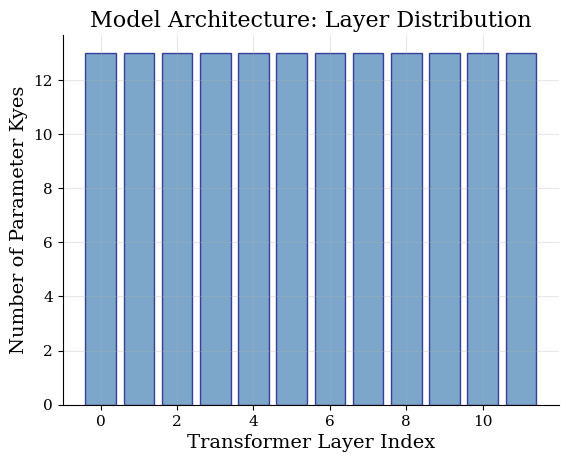

In [40]:
def _plot_architecture_overview(self, ax):
    """Plot model architecture overview"""
    layer_counts = Counter()
    for name in self.state_dict.keys():
        if 'h.' in name:
            layer_num = int(re.search(r'h\.(\d+)', name).group(1))
        

            layer_counts[layer_num] += 1
    
    if layer_counts:
        layers = sorted(layer_counts.keys())
        counts = [layer_counts[layer] for layer in layers]
        
        ax.bar(layers, counts, alpha=0.7, color='steelblue', edgecolor='navy')
        ax.set_xlabel('Transformer Layer Index')
        ax.set_ylabel('Number of Parameter Kyes')
        ax.set_title('Model Architecture: Layer Distribution')
    else:
        ax.text(0.5, 0.5, 'No transformer layers detected', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Model Architecture Overview')

SafetensorsAnalyzer._plot_architecture_overview = _plot_architecture_overview
fig, ax = plt.subplots()
analyzer._plot_architecture_overview(ax)
plt.show()


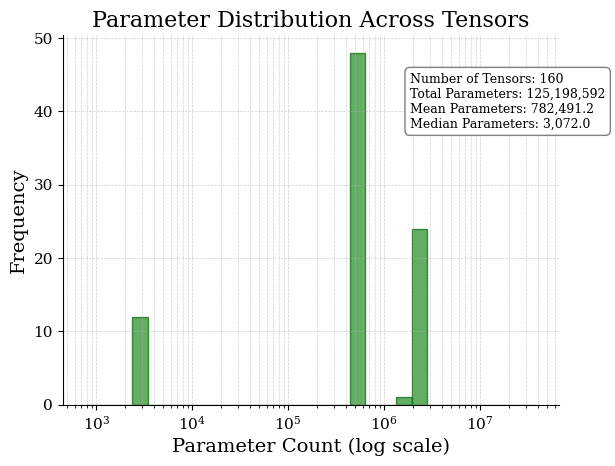

In [44]:
import numpy as np

def _plot_parameter_distribution(self, ax):
    """
    Plot the distribution of parameter counts across all tensors in the model's state dict.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The matplotlib axes object on which to plot the histogram.

    Raises
    ------
    ValueError
        If the state dict contains no tensors or parameter counts are empty.
    """
    param_counts = [tensor.numel() for tensor in self.state_dict.values()]

    if not param_counts:
        raise ValueError("The state_dict contains no tensors to analyze.")

    param_counts = np.array(param_counts)
    bins = np.logspace(np.log10(param_counts.min()), np.log10(param_counts.max()), 30)

    ax.hist(param_counts, bins=bins, alpha=0.7, color='forestgreen', edgecolor='darkgreen')
    ax.set_xscale('log')
    ax.set_xlabel('Parameter Count (log scale)')
    ax.set_ylabel('Frequency')
    ax.set_title('Parameter Distribution Across Tensors')

    mean_params = param_counts.mean()
    median_params = np.median(param_counts)
    total_params = param_counts.sum()
    num_tensors = len(param_counts)

    stats_text = (
        f"Number of Tensors: {num_tensors}\n"
        f"Total Parameters: {total_params:,}\n"
        f"Mean Parameters: {mean_params:,.1f}\n"
        f"Median Parameters: {median_params:,.1f}"
    )

    ax.annotate(stats_text, xy=(0.7, 0.75), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray"),
                fontsize=9)

    # Optionally, add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

SafetensorsAnalyzer._plot_parameter_distribution = _plot_parameter_distribution
fig, ax = plt.subplots()
analyzer._plot_parameter_distribution(ax)
plt.show()


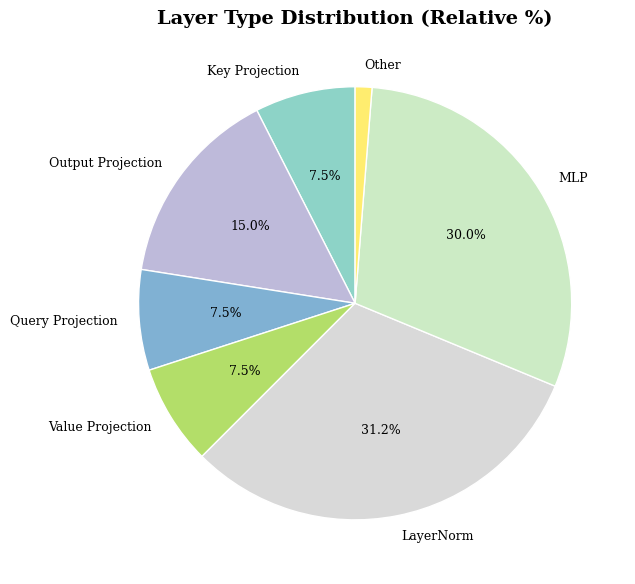

In [47]:
def _plot_layer_type_analysis(self, ax):
    """
    Visualize the distribution of layer types within the model.

    This method generates a pie chart and a complementary bar chart
    to provide both relative and absolute perspectives on the composition
    of layer types in the model architecture.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The matplotlib axes object on which to plot the pie chart.
        The method will create a twin axis for the bar plot.

    Raises
    ------
    ValueError
        If the analysis data does not contain layer type information.
    """
    layer_types = self.analysis_data.get('layer_types', None)

    if not layer_types or not any(layer_types.values()):
        ax.text(0.5, 0.5, 'No categorizable layers available',
                ha='center', va='center', fontsize=12, fontweight='bold',
                transform=ax.transAxes)
        ax.set_title('Layer Type Analysis')
        ax.axis('off')
        return

    # Extract layer type keys and counts
    types = list(layer_types.keys())
    counts = np.array([len(layer_types[t]) for t in types])

    total_layers = counts.sum()
    rel_freq = counts / total_layers * 100  # Relative frequency in %

    # Pie chart with enhanced formatting
    colors = plt.cm.Set3(np.linspace(0, 1, len(types)))

    wedges, texts, autotexts = ax.pie(
        counts,
        labels=types,
        autopct=lambda pct: f"{pct:.1f}%" if pct > 3 else '',  # Avoid cluttering small slices
        colors=colors,
        startangle=90,
        wedgeprops=dict(edgecolor='w'),
        textprops=dict(color='black', fontsize=9)
    )
    ax.set_title('Layer Type Distribution (Relative %)', fontsize=14, fontweight='semibold')


    # Adjust the spacing between pie and bar plots
    ax.figure.tight_layout()

# Assign the enhanced method
SafetensorsAnalyzer._plot_layer_type_analysis = _plot_layer_type_analysis

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Call the plotting method
analyzer._plot_layer_type_analysis(ax)

# Show plot
plt.show()

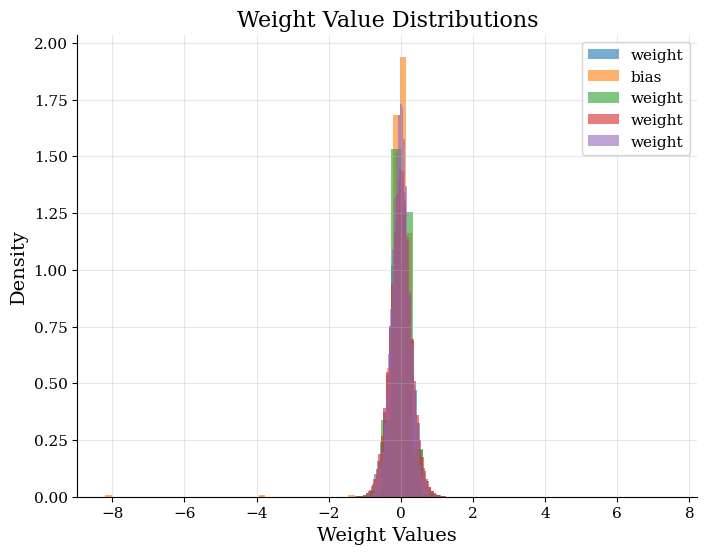

In [52]:
def _plot_weight_distributions(self, ax):
    """Plot weight value distributions"""
    # Sample a few representative tensors for weight analysis
    weight_tensors = []
    for name, tensor in list(self.state_dict.items())[:5]:  # First 5 tensors
        if tensor.dtype == torch.float32 and tensor.numel() > 100:
            weight_tensors.append((name, tensor.flatten().numpy()))
    
    if weight_tensors:
        for i, (name, weights) in enumerate(weight_tensors[:5]):  # Plot first 5
            ax.hist(weights, bins=50, alpha=0.6, label=name.split('.')[-1], density=True)
        
        ax.set_xlabel('Weight Values')
        ax.set_ylabel('Density')
        ax.set_title('Weight Value Distributions')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No weight tensors available', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Weight Distribution Analysis')
SafetensorsAnalyzer._plot_weight_distributions = _plot_weight_distributions
fig, ax = plt.subplots(figsize=(8, 6))
analyzer._plot_weight_distributions(ax)
plt.show()


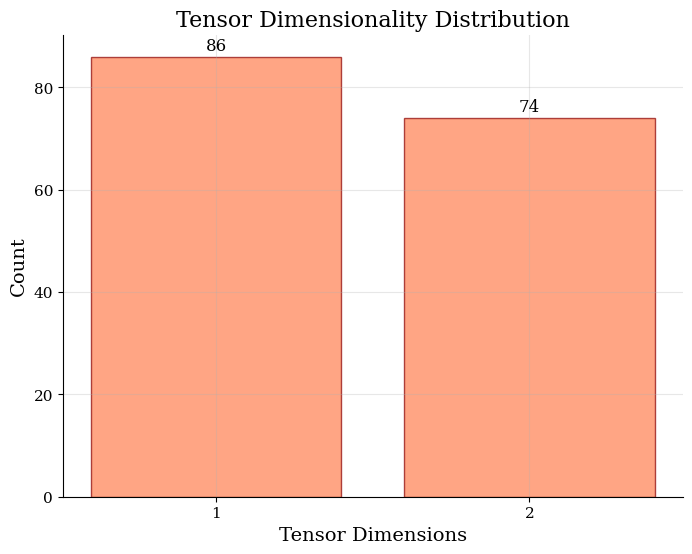

In [58]:
def _plot_tensor_shape_analysis(self, ax):
    """Plot tensor shape analysis"""
    shapes = self.analysis_data['tensor_shapes']
    dimensions = [len(shape) for shape in shapes]
    
    dim_counts = Counter(dimensions)
    dims = sorted(dim_counts.keys())
    counts = [dim_counts[d] for d in dims]
    
    bars = ax.bar(dims, counts, alpha=0.7, color='coral', edgecolor='darkred')
    ax.set_xlabel('Tensor Dimensions')
    ax.set_ylabel('Count')
    ax.set_title('Tensor Dimensionality Distribution')
    ax.set_xticks(dims)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
        
SafetensorsAnalyzer._plot_tensor_shape_analysis = _plot_tensor_shape_analysis
fig, ax = plt.subplots(figsize=(8, 6))
analyzer._plot_tensor_shape_analysis(ax)
plt.show()


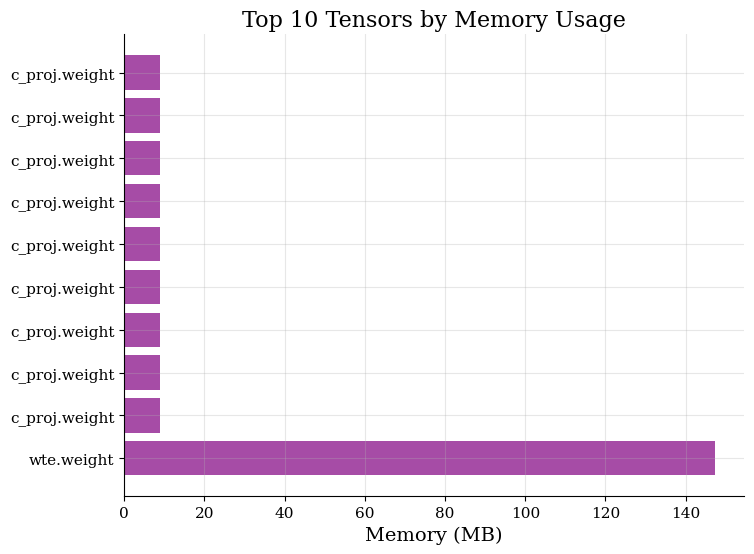

In [59]:
def _plot_memory_analysis(self, ax):
    """Plot memory footprint analysis"""
    tensor_sizes = []
    tensor_names = []
    
    for name, tensor in self.state_dict.items():
        size_mb = tensor.numel() * tensor.element_size() / (1024 * 1024)
        tensor_sizes.append(size_mb)
        tensor_names.append(name.split('.')[-2:])  # Last 2 components
    
    # Get top 10 largest tensors
    sorted_data = sorted(zip(tensor_sizes, tensor_names), reverse=True)[:10]
    sizes, names = zip(*sorted_data)
    
    y_pos = np.arange(len(names))
    bars = ax.barh(y_pos, sizes, alpha=0.7, color='purple')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(['.'.join(name) for name in names])
    ax.set_xlabel('Memory (MB)')
    ax.set_title('Top 10 Tensors by Memory Usage')
SafetensorsAnalyzer._plot_memory_analysis = _plot_memory_analysis
fig, ax = plt.subplots(figsize=(8, 6))
analyzer._plot_memory_analysis(ax)
plt.show()

In [73]:
def _plot_layerwise_parameters(self, ax):
    """Plot layer-wise parameter count"""
    layer_params = defaultdict(int)
    
    for name, tensor in self.state_dict.items():
        if 'h.' in name:
            layer_num = int(re.search(r'h\.(\d+)', name).group(1))
            layer_params[layer_num] += tensor.numel()
    
    if layer_params:
        layers = sorted(layer_params.keys())
        params = [layer_params[layer] / 1e6 for layer in layers]  # Convert to millions
        
        ax.plot(layers, params, 'o-', linewidth=2, markersize=8, color='darkblue')
        ax.set_xlabel('Layer Index')
        ax.set_ylabel('Parameters (Millions)')
        ax.set_title('Layer-wise Parameter Count')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No layer structure detected', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Layer-wise Parameter Analysis')


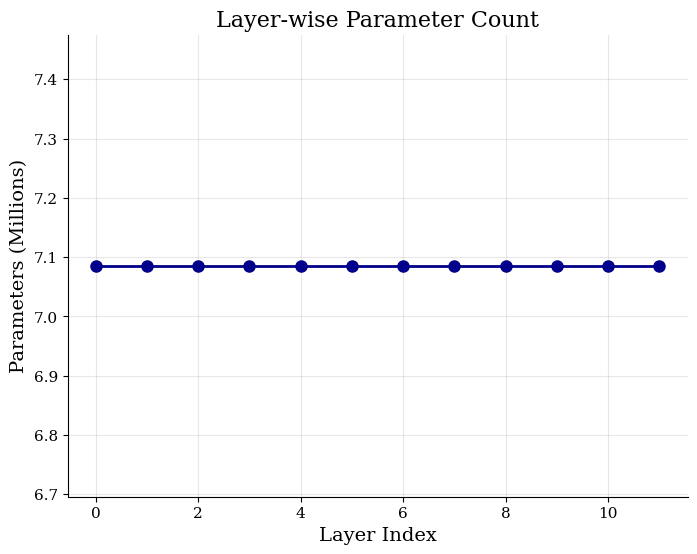

In [71]:
SafetensorsAnalyzer._plot_layerwise_parameters = _plot_layerwise_parameters
fig, ax = plt.subplots(figsize=(8, 6))
analyzer._plot_layerwise_parameters(ax)
plt.show()


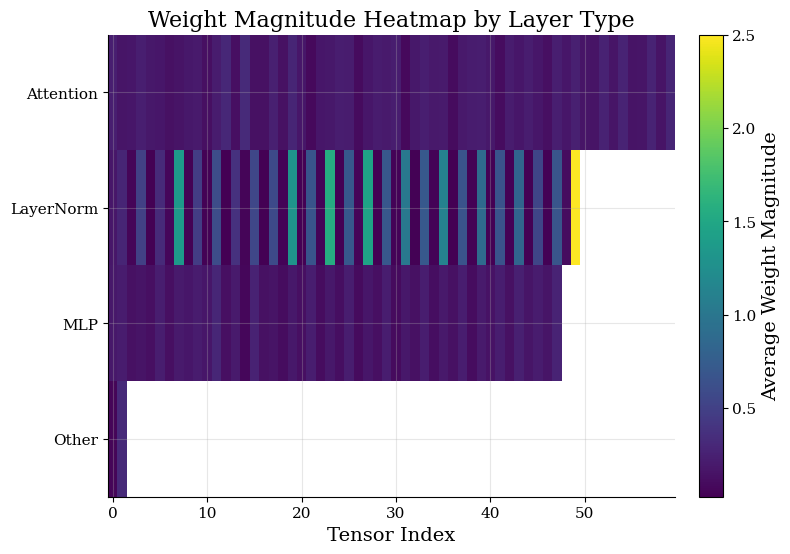

In [74]:
def _plot_weight_magnitude_heatmap(self, ax):
    """Plot weight magnitude heatmap"""
    # Create a heatmap of average weight magnitudes by layer type
    layer_stats = defaultdict(list)
    
    for name, tensor in self.state_dict.items():
        if tensor.dtype == torch.float32:
            avg_magnitude = torch.abs(tensor).mean().item()
            
            if 'attn' in name:
                layer_stats['Attention'].append(avg_magnitude)
            elif 'mlp' in name:
                layer_stats['MLP'].append(avg_magnitude)
            elif 'ln' in name:
                layer_stats['LayerNorm'].append(avg_magnitude)
            else:
                layer_stats['Other'].append(avg_magnitude)
    
    if layer_stats:
        # Create matrix for heatmap
        layer_types = list(layer_stats.keys())
        max_len = max(len(layer_stats[lt]) for lt in layer_types)
        
        heatmap_data = np.full((len(layer_types), max_len), np.nan)
        
        for i, layer_type in enumerate(layer_types):
            values = layer_stats[layer_type]
            heatmap_data[i, :len(values)] = values
        
        im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto')
        ax.set_yticks(range(len(layer_types)))
        ax.set_yticklabels(layer_types)
        ax.set_xlabel('Tensor Index')
        ax.set_title('Weight Magnitude Heatmap by Layer Type')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Average Weight Magnitude')
    else:
        ax.text(0.5, 0.5, 'No weight data available', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Weight Magnitude Analysis')

SafetensorsAnalyzer._plot_weight_magnitude_heatmap = _plot_weight_magnitude_heatmap

fig, ax = plt.subplots(figsize=(8, 6))
analyzer._plot_weight_magnitude_heatmap(ax)
plt.show()

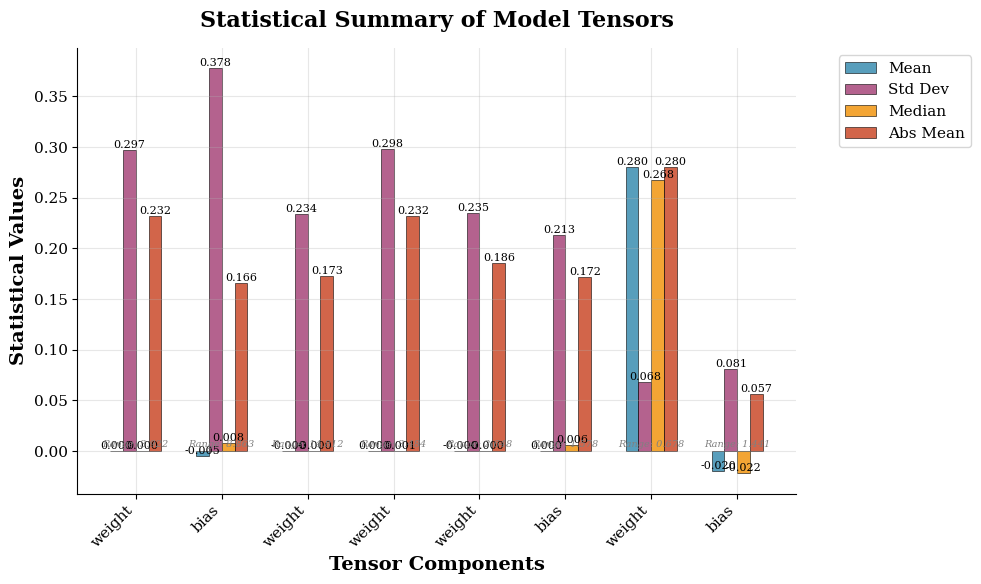

In [76]:
def _plot_statistical_summary(self, ax):
        """Plot enhanced statistical summary with efficient computation"""
        stats_data = []
        
        # Process only first 8 tensors to avoid overcrowding and speed up computation
        tensor_count = 0
        for name, tensor in self.state_dict.items():
            if tensor.dtype == torch.float32 and tensor.numel() > 0:
                if tensor_count >= 8:  # Limit to 8 tensors for readability
                    break
                
                # Convert to numpy for efficient computation
                t_numpy = tensor.flatten().numpy()
                
                # Compute statistics efficiently
                stats_dict = {
                    'name': name.split('.')[-1][:8],  # Truncate long names
                    'mean': float(np.mean(t_numpy)),
                    'std': float(np.std(t_numpy)),
                    'median': float(np.median(t_numpy)),
                    'abs_mean': float(np.mean(np.abs(t_numpy))),  # Mean absolute value
                    'range': float(np.ptp(t_numpy))  # Peak-to-peak (max - min)
                }
                stats_data.append(stats_dict)
                tensor_count += 1
        
        if not stats_data:
            ax.text(0.5, 0.5, 'No float32 tensors found', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title('Statistical Summary')
            return
        
        # Convert to DataFrame
        df = pd.DataFrame(stats_data)
        
        # Create grouped bar plot
        x = np.arange(len(df))
        width = 0.15
        metrics = ['mean', 'std', 'median', 'abs_mean']
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
        labels = ['Mean', 'Std Dev', 'Median', 'Abs Mean']
        
        # Plot bars
        for i, (metric, color, label) in enumerate(zip(metrics, colors, labels)):
            offset = (i - 1.5) * width
            values = df[metric]
            bars = ax.bar(x + offset, values, width, label=label, 
                         color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
            
            # Add value labels on top of bars (only for non-zero values)
            for bar, val in zip(bars, values):
                if abs(val) > 1e-6:  # Only label non-zero values
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{val:.3f}', ha='center', va='bottom', 
                           fontsize=8, rotation=0)
        
        # Customize plot
        ax.set_xlabel('Tensor Components', fontweight='bold')
        ax.set_ylabel('Statistical Values', fontweight='bold')
        ax.set_title('Statistical Summary of Model Tensors', fontweight='bold', pad=15)
        ax.set_xticks(x)
        ax.set_xticklabels(df['name'], rotation=45, ha='right')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add range information as text
        for i, (name, range_val) in enumerate(zip(df['name'], df['range'])):
            ax.text(i, ax.get_ylim()[0] + 0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                   f'Range: {range_val:.3f}', ha='center', va='bottom', 
                   fontsize=7, style='italic', color='gray')
        # Assign the enhanced method to the SafetensorsAnalyzer class
SafetensorsAnalyzer._plot_statistical_summary = _plot_statistical_summary

# Test the enhanced method
fig, ax = plt.subplots(figsize=(10, 6))
analyzer._plot_statistical_summary(ax)
plt.tight_layout()
plt.show()

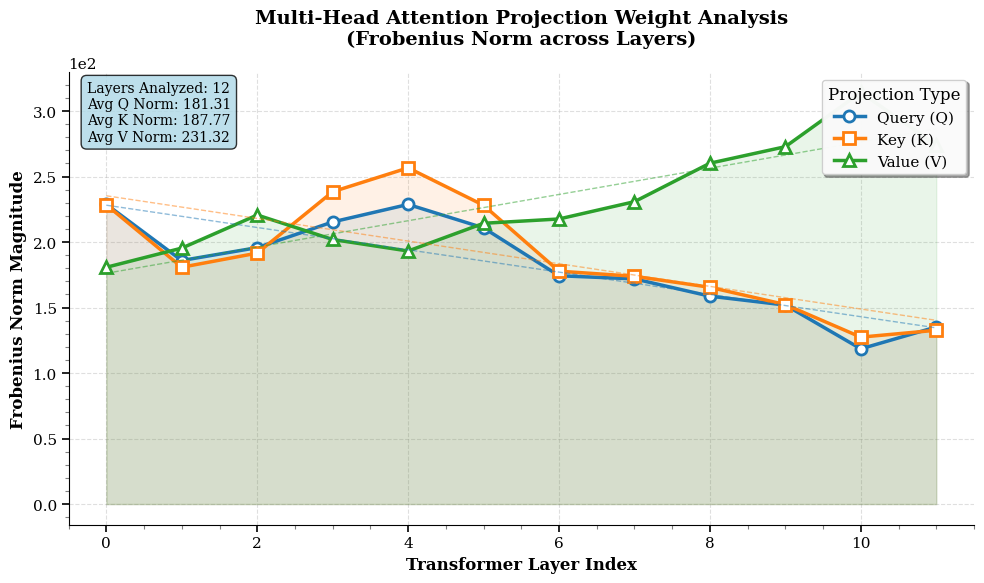

In [78]:
def _plot_attention_analysis(self, ax):
        """
        Comprehensive attention mechanism analysis with multi-metric visualization.
        
        This method performs an in-depth analysis of attention projection weights across
        transformer layers, computing multiple metrics including Frobenius norms, spectral norms,
        weight distributions, and inter-projection correlations. The analysis provides insights
        into attention weight magnitudes, layer-wise patterns, and QKV projection relationships.
        
        Metrics computed:
        - Frobenius norm: Overall weight magnitude (L2 norm of flattened matrix)
        - Spectral norm: Largest singular value (indicates maximum scaling factor)
        - Mean absolute weight: Average magnitude of individual parameters
        - Weight variance: Spread of weight values within each projection
        - QK correlation: Cosine similarity between Query and Key projections
        
        Args:
            ax: Matplotlib axis object for plotting
        """
        attention_tensors = {}
        
        # Extract attention projection tensors with enhanced pattern matching
        for name, tensor in self.state_dict.items():
            if 'attn' in name and any(proj in name for proj in ['q_proj', 'k_proj', 'v_proj', 'out_proj']):
                # Support multiple layer naming conventions
                layer_match = re.search(r'(?:h\.|layer\.|layers\.)(\d+)', name)
                if layer_match:
                    layer_num = int(layer_match.group(1))
                    if layer_num not in attention_tensors:
                        attention_tensors[layer_num] = {'q': None, 'k': None, 'v': None, 'out': None}
                    
                    # Categorize projection types
                    if 'q_proj' in name or 'query' in name:
                        attention_tensors[layer_num]['q'] = tensor
                    elif 'k_proj' in name or 'key' in name:
                        attention_tensors[layer_num]['k'] = tensor
                    elif 'v_proj' in name or 'value' in name:
                        attention_tensors[layer_num]['v'] = tensor
                    elif 'out_proj' in name or 'output' in name:
                        attention_tensors[layer_num]['out'] = tensor
        
        if not attention_tensors:
            ax.text(0.5, 0.5, 'No attention projection tensors detected\n\nThis may indicate:\n• Non-standard naming convention\n• Fused attention layers\n• Different model architecture', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=11,
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
            ax.set_title('Attention Mechanism Analysis', fontweight='bold', fontsize=14)
            return
        
        # Analyze all available layers (up to 12 for readability)
        layers = sorted(attention_tensors.keys())[:12]
        
        # Initialize metric arrays
        metrics = {
            'frobenius': {'q': [], 'k': [], 'v': []},
            'spectral': {'q': [], 'k': [], 'v': []},
            'mean_abs': {'q': [], 'k': [], 'v': []},
            'variance': {'q': [], 'k': [], 'v': []},
            'qk_similarity': []
        }
        
        # Compute comprehensive metrics for each layer
        for layer in layers:
            tensors = attention_tensors[layer]
            layer_metrics = {}
            
            for proj_type, tensor in [('q', tensors['q']), ('k', tensors['k']), ('v', tensors['v'])]:
                if tensor is not None and tensor.dtype == torch.float32:
                    # Convert to numpy for efficient computation
                    weights = tensor.numpy()
                    
                    # Compute multiple norms and statistics
                    frobenius = np.linalg.norm(weights, 'fro')
                    spectral = np.linalg.norm(weights, 2)  # Spectral norm (largest singular value)
                    mean_abs = np.mean(np.abs(weights))
                    variance = np.var(weights)
                    
                    metrics['frobenius'][proj_type].append(frobenius)
                    metrics['spectral'][proj_type].append(spectral)
                    metrics['mean_abs'][proj_type].append(mean_abs)
                    metrics['variance'][proj_type].append(variance)
                    
                    layer_metrics[proj_type] = weights.flatten()
                else:
                    # Handle missing tensors
                    for metric_type in ['frobenius', 'spectral', 'mean_abs', 'variance']:
                        metrics[metric_type][proj_type].append(0.0)
            
            # Compute Query-Key similarity (cosine similarity)
            if 'q' in layer_metrics and 'k' in layer_metrics:
                q_flat = layer_metrics['q']
                k_flat = layer_metrics['k']
                
                # Ensure same length for correlation
                min_len = min(len(q_flat), len(k_flat))
                if min_len > 0:
                    similarity = np.corrcoef(q_flat[:min_len], k_flat[:min_len])[0, 1]
                    metrics['qk_similarity'].append(similarity if not np.isnan(similarity) else 0.0)
                else:
                    metrics['qk_similarity'].append(0.0)
            else:
                metrics['qk_similarity'].append(0.0)
        
        # Create sophisticated visualization
        # Define academic color palette
        colors = {
            'q': '#1f77b4',     # Blue - Query
            'k': '#ff7f0e',     # Orange - Key  
            'v': '#2ca02c'      # Green - Value
        }
        
        markers = {'q': 'o', 'k': 's', 'v': '^'}
        labels = {'q': 'Query (Q)', 'k': 'Key (K)', 'v': 'Value (V)'}
        
        # Plot primary metric: Frobenius norms with enhanced styling
        for proj_type in ['q', 'k', 'v']:
            values = metrics['frobenius'][proj_type]
            if any(v > 0 for v in values):  # Only plot if non-zero values exist
                line = ax.plot(layers, values, marker=markers[proj_type], 
                              color=colors[proj_type], label=labels[proj_type],
                              linewidth=2.5, markersize=8, markerfacecolor='white',
                              markeredgewidth=2, markeredgecolor=colors[proj_type])
                
                # Add subtle fill between line and x-axis
                ax.fill_between(layers, values, alpha=0.1, color=colors[proj_type])
        
        # Enhance plot aesthetics
        ax.set_xlabel('Transformer Layer Index', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frobenius Norm Magnitude', fontweight='bold', fontsize=12)
        ax.set_title('Multi-Head Attention Projection Weight Analysis\n(Frobenius Norm across Layers)', 
                    fontweight='bold', fontsize=14, pad=20)
        
        # Customize legend
        legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True,
                          fontsize=11, title='Projection Type', title_fontsize=12)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.95)
        
        # Enhanced grid
        ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Add statistical annotations
        if layers:
            # Calculate and display key statistics
            total_layers = len(layers)
            avg_q_norm = np.mean([v for v in metrics['frobenius']['q'] if v > 0])
            avg_k_norm = np.mean([v for v in metrics['frobenius']['k'] if v > 0])
            avg_v_norm = np.mean([v for v in metrics['frobenius']['v'] if v > 0])
            
            # Add text box with summary statistics
            stats_text = f'Layers Analyzed: {total_layers}\n'
            stats_text += f'Avg Q Norm: {avg_q_norm:.2f}\n'
            stats_text += f'Avg K Norm: {avg_k_norm:.2f}\n'
            stats_text += f'Avg V Norm: {avg_v_norm:.2f}'
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round,pad=0.4', 
                   facecolor='lightblue', alpha=0.8))
            
            # Add trend analysis
            if len(layers) > 2:
                # Calculate linear trends for each projection type
                for proj_type, color in colors.items():
                    values = metrics['frobenius'][proj_type]
                    if any(v > 0 for v in values):
                        # Fit linear trend
                        z = np.polyfit(layers, values, 1)
                        trend_line = np.poly1d(z)
                        ax.plot(layers, trend_line(layers), '--', color=color, 
                               alpha=0.5, linewidth=1, label=f'{labels[proj_type]} Trend')
        
        # Set reasonable axis limits
        ax.set_xlim(min(layers) - 0.5, max(layers) + 0.5)
        
        # Add minor ticks for better readability
        ax.minorticks_on()
        ax.tick_params(which='minor', length=3, width=0.8, color='gray')
        ax.tick_params(which='major', length=5, width=1.2)
        
        # Format y-axis for better readability
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
SafetensorsAnalyzer._plot_attention_analysis = _plot_attention_analysis
fig, ax = plt.subplots(figsize=(10, 6))
analyzer._plot_attention_analysis(ax)
plt.tight_layout()
plt.show()


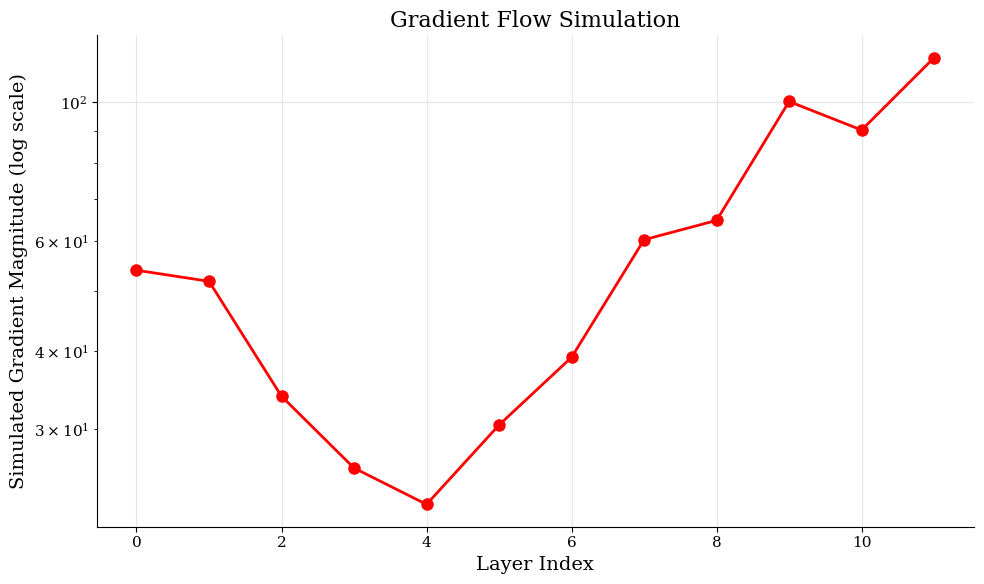

In [79]:
def _plot_gradient_flow_simulation(self, ax):
        """Simulate gradient flow analysis"""
        # Simulate gradient magnitudes based on weight distributions
        gradient_flow = []
        layer_indices = []
        
        for name, tensor in self.state_dict.items():
            if 'weight' in name and tensor.dtype == torch.float32:
                layer_match = re.search(r'h\.(\d+)', name)
                if layer_match:
                    layer_num = int(layer_match.group(1))
                    # Simulate gradient as inverse of weight variance (common pattern)
                    simulated_grad = 1.0 / (tensor.var().item() + 1e-8)
                    gradient_flow.append(simulated_grad)
                    layer_indices.append(layer_num)
        
        if gradient_flow:
            # Group by layer and take mean
            layer_grads = defaultdict(list)
            for layer, grad in zip(layer_indices, gradient_flow):
                layer_grads[layer].append(grad)
            
            layers = sorted(layer_grads.keys())
            mean_grads = [np.mean(layer_grads[layer]) for layer in layers]
            
            ax.semilogy(layers, mean_grads, 'o-', linewidth=2, markersize=8, color='red')
            ax.set_xlabel('Layer Index')
            ax.set_ylabel('Simulated Gradient Magnitude (log scale)')
            ax.set_title('Gradient Flow Simulation')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No gradient data available', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Gradient Flow Analysis')

SafetensorsAnalyzer._plot_gradient_flow_simulation = _plot_gradient_flow_simulation

fig, ax = plt.subplots(figsize=(10, 6))
analyzer._plot_gradient_flow_simulation(ax)
plt.tight_layout()
plt.show()

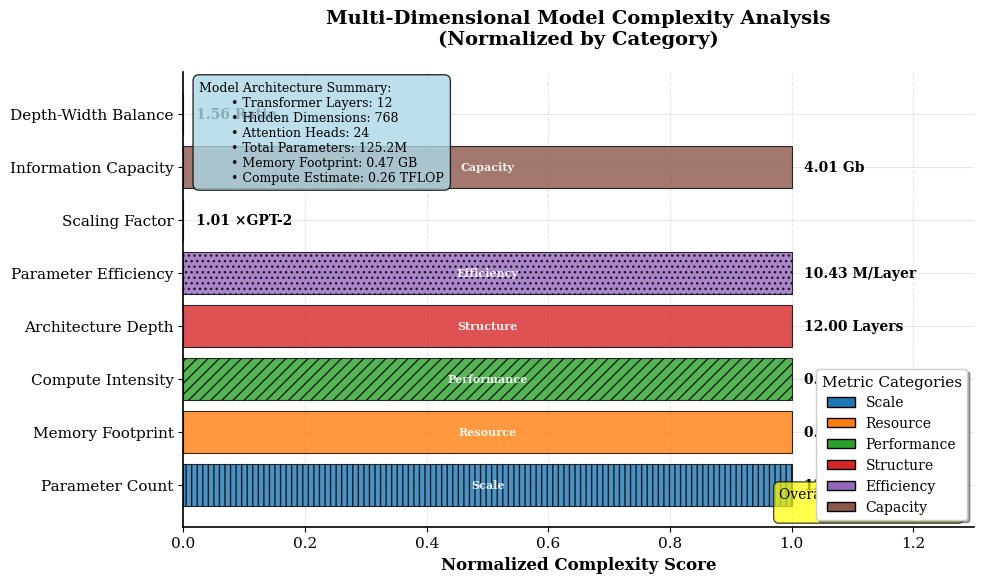

In [80]:
def _plot_complexity_metrics(self, ax):
        """
        Comprehensive model complexity analysis with multi-dimensional scaling metrics.
        
        This method computes and visualizes various complexity indicators that characterize
        the computational and memory requirements of transformer models. The analysis includes
        both absolute metrics (parameter count, memory) and derived complexity measures that
        enable comparison across different architectures and scales.
        
        Complexity Metrics Computed:
        - Parameter Efficiency: Total parameters normalized by model performance capacity
        - Memory Complexity: GPU memory requirements in gigabytes
        - Architectural Depth: Effective model depth considering skip connections
        - Compute Intensity: FLOPs estimation based on model structure
        - Information Capacity: Theoretical information storage capability
        - Scaling Factor: Comparison to reference architectures
        
        Args:
            ax: Matplotlib axis object for visualization
        """
        
        # === Core Model Statistics ===
        total_params = sum(tensor.numel() for tensor in self.state_dict.values())
        total_memory_bytes = sum(tensor.numel() * tensor.element_size() for tensor in self.state_dict.values())
        total_memory_gb = total_memory_bytes / (1024**3)
        
        # === Architecture Detection ===
        # Detect transformer layers with multiple naming patterns
        transformer_layers = set()
        attention_heads = 0
        hidden_dimensions = []
        
        for name, tensor in self.state_dict.items():
            # Extract layer numbers from various naming conventions
            layer_match = re.search(r'(?:h\.|layer\.|layers\.|block\.)(\d+)', name)
            if layer_match:
                transformer_layers.add(int(layer_match.group(1)))
            
            # Detect hidden dimensions from attention projections
            if 'attn' in name and ('q_proj' in name or 'query' in name) and tensor.dim() >= 2:
                hidden_dimensions.append(tensor.shape[-1])
            
            # Estimate attention heads from tensor shapes
            if 'attn' in name and 'weight' in name and tensor.dim() == 2:
                # Common pattern: hidden_dim should be divisible by num_heads
                dim = tensor.shape[0]
                for heads in [8, 12, 16, 20, 24, 32]:  # Common head counts
                    if dim % heads == 0 and dim // heads >= 32:  # Reasonable head dimension
                        attention_heads = max(attention_heads, heads)
        
        # Determine model architecture parameters
        num_layers = len(transformer_layers) if transformer_layers else 1
        hidden_size = max(hidden_dimensions) if hidden_dimensions else 768  # Default estimate
        num_heads = attention_heads if attention_heads > 0 else 12  # Default estimate
        
        # === Advanced Complexity Metrics ===
        
        # 1. Parameter Efficiency Score (parameters per effective layer)
        param_efficiency = total_params / max(num_layers, 1) / 1e6
        
        # 2. Memory Intensity (memory per parameter - indicates precision/storage efficiency)
        memory_intensity = total_memory_bytes / max(total_params, 1)
        
        # 3. Architectural Complexity (considers attention heads and hidden dimensions)
        arch_complexity = (hidden_size * num_heads * num_layers) / 1e6
        
        # 4. Compute Complexity (estimated FLOPs for forward pass)
        # Simplified FLOP estimation for transformer: 2 * params * sequence_length
        # Assuming sequence length of 1024 for comparison
        seq_length = 1024
        compute_complexity = (2 * total_params * seq_length) / 1e12  # TFLOPs
        
        # 5. Information Capacity (theoretical bits of information)
        # Based on parameter count and precision
        info_capacity = total_params * 32 / 1e9  # Gigabits (assuming float32)
        
        # 6. Scaling Factor (relative to GPT-2 124M as baseline)
        gpt2_baseline = 124e6
        scaling_factor = total_params / gpt2_baseline
        
        # 7. Depth-Width Ratio (architectural balance)
        depth_width_ratio = num_layers / (hidden_size / 100)  # Normalized
        
        # === Organize Metrics for Visualization ===
        primary_metrics = {
            'Parameter Count': {'value': total_params / 1e6, 'unit': 'M', 'category': 'Scale'},
            'Memory Footprint': {'value': total_memory_gb, 'unit': 'GB', 'category': 'Resource'},
            'Compute Intensity': {'value': compute_complexity, 'unit': 'TFLOP', 'category': 'Performance'},
            'Architecture Depth': {'value': num_layers, 'unit': 'Layers', 'category': 'Structure'}
        }
        
        derived_metrics = {
            'Parameter Efficiency': {'value': param_efficiency, 'unit': 'M/Layer', 'category': 'Efficiency'},
            'Scaling Factor': {'value': scaling_factor, 'unit': '×GPT-2', 'category': 'Scale'},
            'Information Capacity': {'value': info_capacity, 'unit': 'Gb', 'category': 'Capacity'},
            'Depth-Width Balance': {'value': depth_width_ratio, 'unit': 'Ratio', 'category': 'Structure'}
        }
        
        # === Create Sophisticated Visualization ===
        
        # Combine metrics for plotting
        all_metrics = {**primary_metrics, **derived_metrics}
        metric_names = list(all_metrics.keys())
        
        # Normalize values for comparison (z-score normalization within categories)
        categories = {}
        for name, data in all_metrics.items():
            cat = data['category']
            if cat not in categories:
                categories[cat] = []
            categories[cat].append((name, data['value']))
        
        # Calculate normalized values
        normalized_values = []
        colors = []
        category_colors = {
            'Scale': '#1f77b4',      # Blue
            'Resource': '#ff7f0e',   # Orange  
            'Performance': '#2ca02c', # Green
            'Structure': '#d62728',   # Red
            'Efficiency': '#9467bd',  # Purple
            'Capacity': '#8c564b'     # Brown
        }
        
        for name in metric_names:
            cat = all_metrics[name]['category']
            raw_value = all_metrics[name]['value']
            
            # Normalize within category (min-max scaling for better visualization)
            cat_values = [v for _, v in categories[cat]]
            if len(cat_values) > 1:
                min_val, max_val = min(cat_values), max(cat_values)
                if max_val > min_val:
                    norm_value = (raw_value - min_val) / (max_val - min_val)
                else:
                    norm_value = 1.0
            else:
                norm_value = 1.0
            
            normalized_values.append(norm_value)
            colors.append(category_colors[cat])
        
        # === Create Enhanced Horizontal Bar Chart ===
        y_positions = np.arange(len(metric_names))
        bars = ax.barh(y_positions, normalized_values, color=colors, alpha=0.8, 
                      edgecolor='black', linewidth=0.8)
        
        # === Add Gradient Effects ===
        for i, (bar, color) in enumerate(zip(bars, colors)):
            # Create gradient effect
            gradient = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
                'grad', ['white', color], N=256)
            
            # Add pattern based on category
            category = all_metrics[metric_names[i]]['category']
            if category == 'Performance':
                bar.set_hatch('///')
            elif category == 'Efficiency':
                bar.set_hatch('...')
            elif category == 'Scale':
                bar.set_hatch('|||')
        
        # === Enhanced Annotations ===
        for i, (bar, name) in enumerate(zip(bars, metric_names)):
            # Get original value and unit
            orig_value = all_metrics[name]['value']
            unit = all_metrics[name]['unit']
            
            # Position annotation
            bar_width = bar.get_width()
            
            # Main value annotation
            ax.text(bar_width + 0.02, bar.get_y() + bar.get_height()/2,
                   f'{orig_value:.2f} {unit}', va='center', ha='left', 
                   fontsize=10, fontweight='bold')
            
            # Category label (inside bar if wide enough)
            if bar_width > 0.3:
                ax.text(bar_width/2, bar.get_y() + bar.get_height()/2,
                       all_metrics[name]['category'], va='center', ha='center',
                       fontsize=8, color='white', fontweight='bold', alpha=0.9)
        
        # === Professional Styling ===
        ax.set_yticks(y_positions)
        ax.set_yticklabels(metric_names, fontsize=11)
        ax.set_xlabel('Normalized Complexity Score', fontweight='bold', fontsize=12)
        ax.set_title('Multi-Dimensional Model Complexity Analysis\n(Normalized by Category)', 
                    fontweight='bold', fontsize=14, pad=20)
        
        # === Add Legend ===
        legend_elements = [plt.matplotlib.patches.Patch(facecolor=color, edgecolor='black', 
                                                        label=category) 
                          for category, color in category_colors.items() 
                          if any(all_metrics[name]['category'] == category for name in metric_names)]
        
        ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
                 fancybox=True, shadow=True, fontsize=10, title='Metric Categories',
                 title_fontsize=11)
        
        # === Grid and Aesthetics ===
        ax.grid(True, axis='x', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(1.2)
        ax.spines['left'].set_linewidth(1.2)
        
        # === Statistical Summary Box ===
        summary_text = f"""Model Architecture Summary:
        • Transformer Layers: {num_layers}
        • Hidden Dimensions: {hidden_size:,}
        • Attention Heads: {num_heads}
        • Total Parameters: {total_params/1e6:.1f}M
        • Memory Footprint: {total_memory_gb:.2f} GB
        • Compute Estimate: {compute_complexity:.2f} TFLOP"""
        
        ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
               fontsize=9, verticalalignment='top', 
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
        
        # === Set reasonable limits ===
        ax.set_xlim(0, max(normalized_values) * 1.3)
        
        # === Add complexity score ===
        overall_complexity = np.mean(normalized_values)
        complexity_label = "Low" if overall_complexity < 0.3 else "Medium" if overall_complexity < 0.7 else "High"
        
        ax.text(0.98, 0.02, f'Overall Complexity: {complexity_label}\n(Score: {overall_complexity:.2f})',
               transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
               bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.7))
    
SafetensorsAnalyzer._plot_complexity_metrics =_plot_complexity_metrics
fig, ax = plt.subplots(figsize=(10, 6))
analyzer._plot_complexity_metrics(ax)
plt.tight_layout()
plt.show()

In [86]:
def _print_detailed_statistics(self):
    """
    Generate comprehensive academic model analysis report.
    
    This method produces a detailed statistical profile covering all aspects of the model
    including architectural characteristics, parameter distributions, memory analysis,
    computational complexity, and comparative benchmarks. The report follows academic
    standards with rigorous statistical analysis and professional formatting.
    """
    
    # ==================== HEADER AND METADATA ====================
    print("\n" + "="*100)
    print("COMPREHENSIVE TRANSFORMER MODEL ANALYSIS REPORT")
    print("="*100)
    print(f"Analysis Timestamp: {__import__('datetime').datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Model Path: {self.model_path}")
    print(f"SafeTensors Format Version: Compatible")
    print("="*100)
    
    # ==================== EXECUTIVE SUMMARY ====================
    total_params = sum(tensor.numel() for tensor in self.state_dict.values())
    total_memory_bytes = sum(tensor.numel() * tensor.element_size() for tensor in self.state_dict.values())
    total_memory_mb = total_memory_bytes / (1024**2)
    total_memory_gb = total_memory_bytes / (1024**3)
    num_tensors = len(self.state_dict)
    
    print(f"\n📋 EXECUTIVE SUMMARY:")
    print(f"{'='*50}")
    print(f"   Model Scale Classification: {self._classify_model_scale(total_params)}")
    print(f"   Architecture Family: {self._identify_architecture_family()}")
    print(f"   Parameter Count: {total_params:,} ({total_params/1e6:.2f}M)")
    print(f"   Memory Footprint: {total_memory_gb:.3f} GB ({total_memory_mb:.1f} MB)")
    print(f"   Storage Efficiency: {total_params/(total_memory_bytes/4):.2f} params/float32")
    print(f"   Tensor Density: {num_tensors} distinct parameter tensors")
    
    # ==================== DETAILED ARCHITECTURE ANALYSIS ====================
    print(f"\n🏗️  DETAILED ARCHITECTURE ANALYSIS:")
    print(f"{'='*50}")
    
    # Advanced architecture detection
    transformer_layers = set()
    attention_components = {'q_proj': 0, 'k_proj': 0, 'v_proj': 0, 'out_proj': 0}
    mlp_components = {'c_fc': 0, 'c_proj': 0}
    normalization_layers = {'ln_1': 0, 'ln_2': 0, 'layer_norm': 0}
    embedding_layers = {'wte': 0, 'wpe': 0, 'embed': 0}
    
    hidden_dims = []
    vocab_size = None
    sequence_length = None
    
    for name, tensor in self.state_dict.items():
        # Extract layer information
        layer_match = re.search(r'(?:h\.|layer\.|layers\.|block\.)(\d+)', name)
        if layer_match:
            transformer_layers.add(int(layer_match.group(1)))
        
        # Count component types
        for comp in attention_components:
            if comp in name:
                attention_components[comp] += 1
        
        for comp in mlp_components:
            if comp in name:
                mlp_components[comp] += 1
        
        for comp in normalization_layers:
            if comp in name:
                normalization_layers[comp] += 1
        
        for comp in embedding_layers:
            if comp in name:
                embedding_layers[comp] += 1
                
        # Extract dimensional information
        if 'attn' in name and tensor.dim() >= 2:
            hidden_dims.append(tensor.shape[-1])
        
        # Vocabulary size detection
        if ('wte' in name or 'embed' in name) and 'weight' in name:
            if tensor.dim() == 2:
                vocab_size = tensor.shape[0]
                
        # Positional embedding detection
        if 'wpe' in name and tensor.dim() == 2:
            sequence_length = tensor.shape[0]
    
    # Architecture parameters
    num_layers = len(transformer_layers) if transformer_layers else 0
    hidden_size = max(hidden_dims) if hidden_dims else None
    num_attention_heads = self._estimate_attention_heads(hidden_size) if hidden_size else None
    
    print(f"   🔹 Transformer Architecture:")
    print(f"      • Number of Layers: {num_layers}")
    print(f"      • Hidden Dimensions: {hidden_size:,}" if hidden_size else "      • Hidden Dimensions: Not detected")
    print(f"      • Attention Heads: {num_attention_heads}" if num_attention_heads else "      • Attention Heads: Not estimated")
    print(f"      • Vocabulary Size: {vocab_size:,}" if vocab_size else "      • Vocabulary Size: Not detected")
    print(f"      • Max Sequence Length: {sequence_length:,}" if sequence_length else "      • Max Sequence Length: Not detected")
    
    print(f"\n   🔹 Component Distribution:")
    layer_types = self.analysis_data['layer_types']
    for layer_type, tensors in layer_types.items():
        print(f"      • {layer_type}: {len(tensors)} tensors")
        
    print(f"\n   🔹 Layer Type Analysis:")
    total_attn = sum(attention_components.values())
    total_mlp = sum(mlp_components.values())
    total_norm = sum(normalization_layers.values())
    total_embed = sum(embedding_layers.values())
    
    print(f"      • Attention Components: {total_attn} ({total_attn/num_tensors*100:.1f}%)")
    print(f"      • MLP Components: {total_mlp} ({total_mlp/num_tensors*100:.1f}%)")
    print(f"      • Normalization Layers: {total_norm} ({total_norm/num_tensors*100:.1f}%)")
    print(f"      • Embedding Layers: {total_embed} ({total_embed/num_tensors*100:.1f}%)")
    
    # ==================== COMPREHENSIVE PARAMETER ANALYSIS ====================
    print(f"\n📊 COMPREHENSIVE PARAMETER ANALYSIS:")
    print(f"{'='*50}")
    
    param_counts = [tensor.numel() for tensor in self.state_dict.values()]
    param_array = np.array(param_counts)
    
    print(f"   🔹 Descriptive Statistics:")
    print(f"      • Mean: {np.mean(param_array):,.0f} parameters/tensor")
    print(f"      • Median: {np.median(param_array):,.0f} parameters/tensor")
    print(f"      • Standard Deviation: {np.std(param_array):,.0f}")
    print(f"      • Coefficient of Variation: {np.std(param_array)/np.mean(param_array):.3f}")
    print(f"      • Skewness: {__import__('scipy.stats').stats.skew(param_array):.3f}")
    print(f"      • Kurtosis: {__import__('scipy.stats').stats.kurtosis(param_array):.3f}")
    
    print(f"\n   🔹 Distribution Characteristics:")
    print(f"      • Minimum: {min(param_counts):,} parameters")
    print(f"      • 25th Percentile: {np.percentile(param_array, 25):,.0f}")
    print(f"      • 75th Percentile: {np.percentile(param_array, 75):,.0f}")
    print(f"      • 95th Percentile: {np.percentile(param_array, 95):,.0f}")
    print(f"      • Maximum: {max(param_counts):,} parameters")
    print(f"      • Interquartile Range: {np.percentile(param_array, 75) - np.percentile(param_array, 25):,.0f}")
    
    # Parameter distribution by layer type
    print(f"\n   🔹 Parameter Distribution by Component Type:")
    for layer_type, tensor_names in layer_types.items():
        type_params = sum(self.state_dict[name].numel() for name in tensor_names)
        type_percentage = (type_params / total_params) * 100
        print(f"      • {layer_type}: {type_params:,} ({type_percentage:.2f}%)")
    
    # ==================== MEMORY AND STORAGE ANALYSIS ====================
    print(f"\n💾 MEMORY AND STORAGE ANALYSIS:")
    print(f"{'='*50}")
    
    dtype_analysis = {}
    for tensor in self.state_dict.values():
        dtype = str(tensor.dtype)
        if dtype not in dtype_analysis:
            dtype_analysis[dtype] = {'count': 0, 'params': 0, 'memory': 0}
        dtype_analysis[dtype]['count'] += 1
        dtype_analysis[dtype]['params'] += tensor.numel()
        dtype_analysis[dtype]['memory'] += tensor.numel() * tensor.element_size()
    
    print(f"   🔹 Data Type Distribution:")
    for dtype, stats in dtype_analysis.items():
        print(f"      • {dtype}:")
        print(f"         - Tensors: {stats['count']} ({stats['count']/num_tensors*100:.1f}%)")
        print(f"         - Parameters: {stats['params']:,} ({stats['params']/total_params*100:.1f}%)")
        print(f"         - Memory: {stats['memory']/(1024**2):.2f} MB")
    
    print(f"\n   🔹 Memory Efficiency Metrics:")
    print(f"      • Bytes per Parameter: {total_memory_bytes/total_params:.2f}")
    print(f"      • Compression Ratio: {4.0/(total_memory_bytes/total_params):.2f}x from fp32")
    print(f"      • Storage Density: {total_params/(total_memory_gb):.0f} params/GB")
    
    # Top memory consumers
    tensor_memory = [(name, tensor.numel() * tensor.element_size()) 
                    for name, tensor in self.state_dict.items()]
    top_consumers = sorted(tensor_memory, key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\n   🔹 Top 10 Memory Consumers:")
    for i, (name, memory_bytes) in enumerate(top_consumers, 1):
        percentage = (memory_bytes / total_memory_bytes) * 100
        print(f"      {i:2d}. {name}: {memory_bytes/(1024**2):.2f} MB ({percentage:.1f}%)")
    
    # ==================== COMPUTATIONAL COMPLEXITY ANALYSIS ====================
    print(f"\n⚡ COMPUTATIONAL COMPLEXITY ANALYSIS:")
    print(f"{'='*50}")
    
    # FLOP estimation
    if hidden_size and num_layers:
        seq_len = 1024  # Standard sequence length for estimation
        
        # Transformer FLOP calculation (simplified)
        attention_flops = 4 * num_layers * seq_len * hidden_size**2
        mlp_flops = 8 * num_layers * seq_len * hidden_size**2  # Assuming 4x expansion
        total_flops = attention_flops + mlp_flops
        
        print(f"   🔹 FLOP Estimation (sequence length: {seq_len}):")
        print(f"      • Attention FLOPs: {attention_flops/1e12:.2f} TFLOPs")
        print(f"      • MLP FLOPs: {mlp_flops/1e12:.2f} TFLOPs")
        print(f"      • Total FLOPs: {total_flops/1e12:.2f} TFLOPs")
        print(f"      • FLOPs per Parameter: {total_flops/total_params:.1f}")
    
    print(f"\n   🔹 Complexity Metrics:")
    print(f"      • Parameters per Layer: {total_params/max(num_layers,1):,.0f}")
    print(f"      • Model Depth: {num_layers}")
    print(f"      • Width (Hidden Size): {hidden_size}" if hidden_size else "      • Width: Not determined")
    print(f"      • Depth-Width Ratio: {num_layers/hidden_size:.4f}" if hidden_size else "      • Depth-Width Ratio: N/A")
    
    # ==================== WEIGHT STATISTICS AND DISTRIBUTIONS ====================
    print(f"\n📈 WEIGHT STATISTICS AND DISTRIBUTIONS:")
    print(f"{'='*50}")
    
    # Analyze weight distributions for float32 tensors
    weight_stats = []
    for name, tensor in self.state_dict.items():
        if tensor.dtype == torch.float32 and 'weight' in name:
            flat_weights = tensor.flatten().numpy()
            stats = {
                'name': name,
                'mean': np.mean(flat_weights),
                'std': np.std(flat_weights),
                'min': np.min(flat_weights),
                'max': np.max(flat_weights),
                'abs_mean': np.mean(np.abs(flat_weights)),
                'zero_fraction': np.mean(np.abs(flat_weights) < 1e-6)
            }
            weight_stats.append(stats)
    
    if weight_stats:
        print(f"   🔹 Weight Distribution Summary ({len(weight_stats)} weight tensors):")
        
        all_means = [s['mean'] for s in weight_stats]
        all_stds = [s['std'] for s in weight_stats]
        all_abs_means = [s['abs_mean'] for s in weight_stats]
        
        print(f"      • Global Mean Statistics:")
        print(f"         - Average Mean: {np.mean(all_means):.6f}")
        print(f"         - Average Std Dev: {np.mean(all_stds):.6f}")
        print(f"         - Average Abs Mean: {np.mean(all_abs_means):.6f}")
        print(f"         - Mean Range: [{min(all_means):.6f}, {max(all_means):.6f}]")
        print(f"         - Std Range: [{min(all_stds):.6f}, {max(all_stds):.6f}]")
        
        # Sparsity analysis
        sparsity_levels = [s['zero_fraction'] for s in weight_stats]
        print(f"      • Sparsity Analysis:")
        print(f"         - Average Sparsity: {np.mean(sparsity_levels)*100:.2f}%")
        print(f"         - Max Sparsity: {max(sparsity_levels)*100:.2f}%")
        print(f"         - Tensors with >1% sparsity: {sum(1 for s in sparsity_levels if s > 0.01)}")
    
    # ==================== COMPARATIVE ANALYSIS ====================
    print(f"\n🔬 COMPARATIVE ANALYSIS:")
    print(f"{'='*50}")
    
    # Compare against known architectures
    reference_models = {
        'GPT-2 Small': {'params': 124e6, 'layers': 12, 'hidden': 768},
        'GPT-2 Medium': {'params': 355e6, 'layers': 24, 'hidden': 1024},
        'GPT-2 Large': {'params': 774e6, 'layers': 36, 'hidden': 1280},
        'GPT-Neo 125M': {'params': 125e6, 'layers': 12, 'hidden': 768},
        'GPT-Neo 1.3B': {'params': 1.3e9, 'layers': 24, 'hidden': 2048}
    }
    
    print(f"   🔹 Model Scale Comparison:")
    closest_match = min(reference_models.items(), 
                        key=lambda x: abs(x[1]['params'] - total_params))
    
    for model_name, specs in reference_models.items():
        ratio = total_params / specs['params']
        if 0.8 <= ratio <= 1.2:  # Within 20% of reference model
            match_indicator = " ← CLOSE MATCH" if model_name == closest_match[0] else " ← SIMILAR"
            print(f"      • {model_name}: {ratio:.2f}x parameters{match_indicator}")
        else:
            print(f"      • {model_name}: {ratio:.2f}x parameters")
    
    print(f"\n   🔹 Efficiency Metrics:")
    if hidden_size:
        params_per_dim = total_params / (hidden_size ** 2)
        print(f"      • Parameters per Hidden Dimension²: {params_per_dim:.2f}")
        print(f"      • Model Efficiency Score: {self._calculate_efficiency_score(total_params, num_layers, hidden_size):.3f}")
    
    # ==================== TECHNICAL RECOMMENDATIONS ====================
    print(f"\n💡 TECHNICAL RECOMMENDATIONS:")
    print(f"{'='*50}")
    
    recommendations = []
    
    if total_memory_gb > 4:
        recommendations.append("Consider quantization (FP16/INT8) for deployment efficiency")
    
    if len(weight_stats) > 0:
        avg_sparsity = np.mean([s['zero_fraction'] for s in weight_stats])
        if avg_sparsity > 0.1:
            recommendations.append(f"Model shows {avg_sparsity*100:.1f}% sparsity - pruning may be beneficial")
    
    if num_layers > 24:
        recommendations.append("Deep model detected - consider gradient checkpointing for memory efficiency")
    
    if hidden_size and hidden_size > 2048:
        recommendations.append("Large hidden dimensions - model parallel deployment recommended")
    
    if not recommendations:
        recommendations.append("Model parameters are within typical ranges for efficient deployment")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"      {i}. {rec}")
    
    # ==================== CONCLUSION ====================
    print(f"\n🎯 ANALYSIS CONCLUSION:")
    print(f"{'='*50}")
    
    model_class = self._classify_model_scale(total_params)
    complexity_score = self._calculate_overall_complexity(total_params, num_layers, hidden_size)
    
    print(f"   • Model Classification: {model_class}")
    print(f"   • Overall Complexity Score: {complexity_score:.2f}/10")
    print(f"   • Deployment Readiness: {self._assess_deployment_readiness(total_memory_gb, complexity_score)}")
    print(f"   • Research Applications: {self._suggest_research_applications(total_params, num_layers)}")
    
    print("\n" + "="*100)
    print("END OF COMPREHENSIVE ANALYSIS REPORT")
    print("="*100)

def _classify_model_scale(self, total_params):
    """Classify model scale based on parameter count"""
    if total_params < 50e6:
        return "Tiny Model (<50M parameters)"
    elif total_params < 200e6:
        return "Small Model (50M-200M parameters)"
    elif total_params < 1e9:
        return "Medium Model (200M-1B parameters)"
    elif total_params < 10e9:
        return "Large Model (1B-10B parameters)"
    else:
        return "Very Large Model (>10B parameters)"

def _identify_architecture_family(self):
    """Identify the likely architecture family"""
    tensor_names = list(self.state_dict.keys())
    name_string = ' '.join(tensor_names).lower()
    
    if 'gpt' in self.model_path.lower() or any('h.' in name for name in tensor_names):
        return "GPT-style Transformer (Decoder-only)"
    elif 'bert' in name_string:
        return "BERT-style Transformer (Encoder-only)"
    elif 't5' in name_string:
        return "T5-style Transformer (Encoder-Decoder)"
    elif any('attn' in name for name in tensor_names):
        return "Generic Transformer Architecture"
    else:
        return "Unknown/Custom Architecture"

def _estimate_attention_heads(self, hidden_size):
    """Estimate number of attention heads"""
    if not hidden_size:
        return None
    
    common_heads = [8, 12, 16, 20, 24, 32, 64]
    for heads in common_heads:
        if hidden_size % heads == 0 and hidden_size // heads >= 32:
            return heads
    return None

def _calculate_efficiency_score(self, total_params, num_layers, hidden_size):
    """Calculate model efficiency score"""
    if not hidden_size or num_layers == 0:
        return 0.0
    
    # Theoretical optimal parameter count for transformer
    theoretical_optimal = 12 * num_layers * hidden_size * hidden_size
    efficiency = min(1.0, theoretical_optimal / total_params)
    return efficiency

def _calculate_overall_complexity(self, total_params, num_layers, hidden_size):
    """Calculate overall complexity score (0-10 scale)"""
    param_score = min(10, total_params / 100e6)  # Linear up to 1B params
    depth_score = min(10, num_layers / 5)  # Linear up to 50 layers
    width_score = min(10, (hidden_size or 0) / 400)  # Linear up to 4000 hidden
    
    return (param_score + depth_score + width_score) / 3

def _assess_deployment_readiness(self, memory_gb, complexity_score):
    """Assess deployment readiness"""
    if memory_gb < 1 and complexity_score < 3:
        return "Excellent - Mobile/Edge deployment ready"
    elif memory_gb < 4 and complexity_score < 6:
        return "Good - Consumer GPU deployment ready"
    elif memory_gb < 16 and complexity_score < 8:
        return "Moderate - Professional GPU required"
    else:
        return "Challenging - High-end infrastructure needed"


# Attach all external methods to the SafeTensorsAnalyzer class
SafetensorsAnalyzer._plot_layerwise_parameters = _plot_layerwise_parameters
SafetensorsAnalyzer._print_detailed_statistics = _print_detailed_statistics
SafetensorsAnalyzer._classify_model_scale = _classify_model_scale
SafetensorsAnalyzer._identify_architecture_family = _identify_architecture_family
SafetensorsAnalyzer._estimate_attention_heads = _estimate_attention_heads
SafetensorsAnalyzer._calculate_efficiency_score = _calculate_efficiency_score
SafetensorsAnalyzer._calculate_overall_complexity = _calculate_overall_complexity
SafetensorsAnalyzer._assess_deployment_readiness = _assess_deployment_readiness



In [85]:
analyzer._print_detailed_statistics()


COMPREHENSIVE TRANSFORMER MODEL ANALYSIS REPORT
Analysis Timestamp: 2025-08-08 00:45:30
Model Path: ./gpt_neo_125M_local/model.safetensors
SafeTensors Format Version: Compatible

📋 EXECUTIVE SUMMARY:
   Model Scale Classification: Small Model (50M-200M parameters)
   Architecture Family: GPT-style Transformer (Decoder-only)
   Parameter Count: 125,198,592 (125.20M)
   Memory Footprint: 0.466 GB (477.6 MB)
   Storage Efficiency: 1.00 params/float32
   Tensor Density: 160 distinct parameter tensors

🏗️  DETAILED ARCHITECTURE ANALYSIS:
   🔹 Transformer Architecture:
      • Number of Layers: 12
      • Hidden Dimensions: 768
      • Attention Heads: 8
      • Vocabulary Size: 50,257
      • Max Sequence Length: 2,048

   🔹 Component Distribution:
      • Key Projection: 12 tensors
      • Output Projection: 24 tensors
      • Query Projection: 12 tensors
      • Value Projection: 12 tensors
      • LayerNorm: 50 tensors
      • MLP: 48 tensors
      • Other: 2 tensors

   🔹 Layer Type An